In [2]:
import os
import numpy as np
import mne
import imageio
import h5py
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')
import analys_func
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance
import tqdm
# sys.path.append('./PCI/')
# sys.path.append('./PCI/PCIst')
# import pci_st as pci
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [44]:
######## General Infos

path_patient_analysis = 'y:\\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500

EEG_CR = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_'+cond_folder+'.npy')
stimlist = pd.read_csv(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv')

#EEG_resp = np.load(path_patient_analysis + '\\' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

badchans  = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])

bad_stims = np.where(labels_region=='OUT')[0]

##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [49]:
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial    = pd.read_csv(file_con)
#M_N1peaks = np.load(file_MN1)

## Cluster trials into 2-3 groups

In [51]:
import Cluster_func as Cf

In [52]:
Fs_rs = 100
num_rs = int(2000/Fs * Fs_rs)

In [14]:
def get_pearson2mean(x_gt, x_trials, tx=1, ty=1, win=0.1, Fs=500):
    x0 = int(tx * Fs)
    x1 = int(x0 + win * Fs)
    y0 = int(ty * Fs)
    y1 = int(y0 + win * Fs)
    if len(x_trials.shape) == 1:
        corr = np.corrcoef(x_gt[x0:x1], x_trials[y0:y1])[0, 1]
    else:
        corr = np.corrcoef(x_gt[x0:x1], x_trials[:, y0:y1])[0, 1:]

    return corr

In [15]:
def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------
    Output : 1D Array of indices in the input array that satisfy the
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found

In [64]:
# 1. select channel
sc = 1
rc = 52
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]


In [65]:
# 2. get start of response
w=0.25
t_0 = 1
resp_all = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 45, Fs))
LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all, 0), 0), Fs, w)
LL_t = np.array(LL_resp[0, 0, :] > np.percentile(LL_resp[0, 0, 0:int((t_0-w/2)*Fs)], 99))*1
t_resp_all = search_sequence_numpy(LL_t,np.ones((int(0.1*Fs),)))
if len(t_resp_all) > 0:
    t_resp = np.round(t_resp_all[0]/Fs-t_0+w/2,3)
    if t_resp < 0.01:
        t_resp = 0
    if t_resp > 0.5:
        t_resp = 0
else:
    t_resp = np.nan
t_resp

0

NameError: name 'sig' is not defined

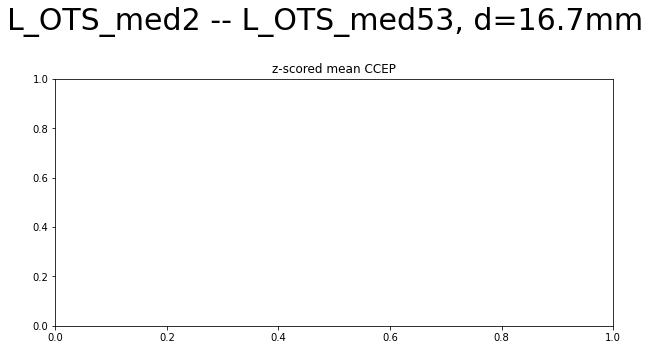

In [66]:
## figure
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
gs       = fig.add_gridspec(2,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax = fig.add_subplot(gs[0,0])
plt.title('z-scored mean CCEP')
plt.plot(x_ax, resp_all, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig==c)))
plt.xlim([-0.5,1.5])
plt.ylabel('[]')
plt.axvline(t_resp, color=[1,0,0],label='start resp')
plt.axvline(0, color=[0,0,0])

ax = fig.add_subplot(gs[1,0])
plt.title('LL w=250ms')
plt.ylabel('[uV/ms]')
plt.axvline(0, color=[0,0,0])
plt.plot(x_ax, LL_resp[0,0,:], color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig==c)))
plt.axhline(np.percentile(LL_resp[0, 0, 0:int((t_0-w/2)*Fs)], 99), label='99th')
plt.plot(t_resp_all[0]/Fs-t_0,  LL_resp[0,0,t_resp_all[0]], 'o', color=[1,0,0], markersize=10)
plt.axvline(t_resp, color=[1,0,0],label='start resp')
ax.annotate('', xy=(t_resp, LL_resp[0,0,t_resp_all[0]]), xytext=(t_resp_all[0]/Fs-t_0,LL_resp[0,0,t_resp_all[0]]),
            arrowprops={'arrowstyle': '-|>', 'lw': 2, 'color': 'red'}, va='center')
    #plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
plt.legend()
plt.xlabel('time [s]')
plt.xlim([-0.5,1.5])


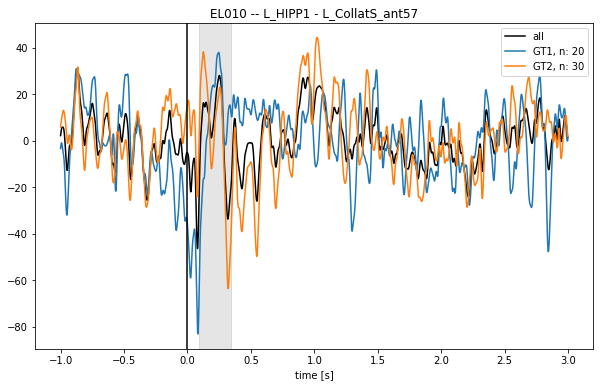

In [59]:
w_cluster = 0.25
plt.figure(figsize=(10,6))
plt.title(subj+' -- '+labels_h[sc]+' - '+labels_h[rc])
#all
n_cluster = 2
M_GT = np.zeros((n_cluster+1,2000))

EEG_trial = ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int'),:],45,Fs)
EEG_trial = signal.resample(EEG_trial, int(num_rs),axis = 1)
EEG_trial = stats.zscore(EEG_trial, axis=1)
cc, y, dist, dist_cc = Cf.dba_cluster(EEG_trial[:,int((t_0+t_resp)*Fs_rs):int((t_0+t_resp+w_cluster)*Fs_rs)],n_cluster)


M_GT[0,:] =ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),45,Fs)
plt.plot(x_ax, M_GT[0,:], color = [0,0,0], label='all')

for c in range(n_cluster):
    M_GT[c+1,:] =ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y==c],:],0),45,Fs)
    plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y==c],:],0),45,Fs), label='GT'+str(c+1)+', n: '+str(sum(y==c)))

plt.legend()
plt.xlabel('time [s]')
plt.axvline(0, color=[0,0,0])
plt.axvspan(t_resp,t_resp+w_cluster, color=[0,0,0], alpha=0.1)

In [60]:
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
# LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster, 1, 0)
# surr
exp = 2
pear_surr_all = []
for t_test in [0, 0.2, 0.5, 1.5, 2.5]:

    pear = get_pearson2mean(M_GT[1,:], EEG_trials[0], tx=t_0+t_resp, ty=t_test, win=w_cluster, Fs=500)  # Pearson# Pearson
    pear2 = get_pearson2mean(M_GT[2,:], EEG_trials[0], tx=t_0+t_resp, ty=t_test, win=w_cluster, Fs=500)  # Pearson# Pearson
    #LL = LL_trials[0,:,int(t_test+w_cluster/2)*Fs]
    pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
    # pear_surr = np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
    pear_surr_all = np.concatenate([pear_surr_all,pear_surr])


# real
t_test = t_0+t_resp
pear = get_pearson2mean(M_GT[1,:], EEG_trials[0], tx=t_0+t_resp, ty=t_test, win=w_cluster, Fs=500)  # Pearson# Pearson
pear2 = get_pearson2mean(M_GT[2,:], EEG_trials[0], tx=t_0+t_resp, ty=t_test, win=w_cluster, Fs=500)  # Pearson# Pearson
#LL = LL_trials[0,:,int(t_test+w_cluster/2)*Fs]
pear =np.arctanh(np.max([pear,pear2],0))*LL# np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL

sig = (pear>np.percentile(pear_surr_all,95))*1

plt.hist(pear_surr_all, label='surr', alpha= 0.5)
plt.axvline(np.percentile(pear_surr_all,95), color=[0,0,0], label = '95th')
plt.hist(pear, label='trials', alpha= 0.8)
plt.xlabel('arctanh(Pears) *LL')
#plt.xlabel('Pears^'+str(exp)+' *LL')
plt.legend()

NameError: name 'LL' is not defined

In [61]:
sig_label  =['Non-sig', 'Sig']

NameError: name 'sig' is not defined

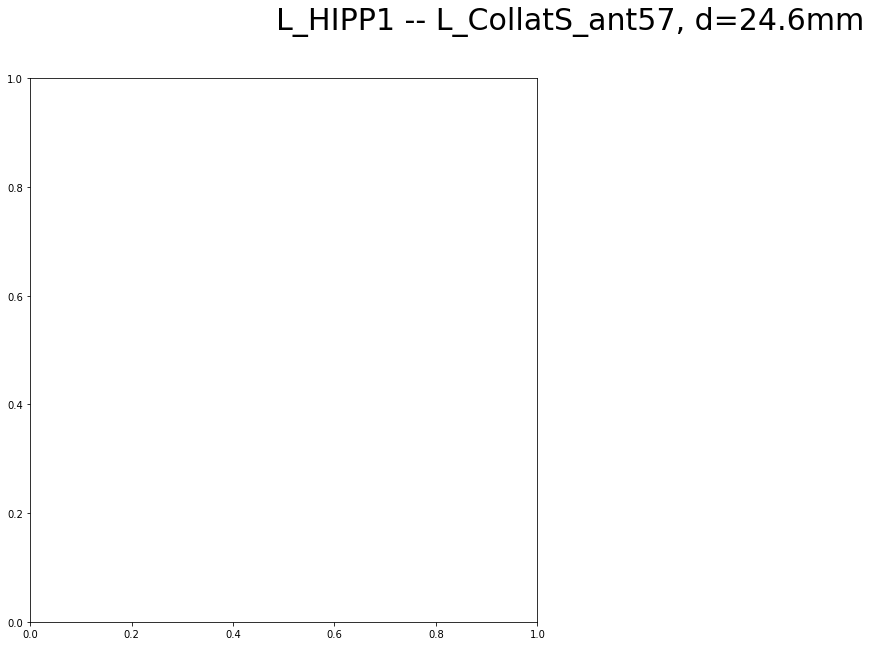

In [62]:
## figure
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
gs       = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])

for c in range(2):
    if c == 0:
        ax = fig.add_subplot(gs[0,c])
    else:
        fig.add_subplot(gs[0,c], sharey=ax)
    mn = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[sig==c],:],0),40,Fs)
    # st = np.std(EEG_CR[rc, dat.Num.values.astype('int')[sig==c],:],0)
    plt.title(sig_label[c])
    for i in range(np.sum(sig==c)):
        plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int')[sig==c][i],:],40,Fs), color=color_elab[c*2], alpha=0.1)
    plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig==c)))
    #plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
    plt.xlabel('time [s]')
    plt.xlim([-0.5,1.5])
    plt.axvline(0, color=[0,0,0])
    plt.ylim([-500,500])
    plt.legend()

In [63]:
plt.figure(figsize=(8,6))
for c in range(2):
    mn = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[sig==c],:],0),40,Fs)
    st = np.std(EEG_CR[rc, dat.Num.values.astype('int')[sig==c],:],0)
    plt.plot(x_ax, mn, color=color_elab[c*2], linewidth= 5, label='n: '+str(np.sum(sig==c)))
    plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
plt.legend()
plt.xlabel('time [s]')
plt.xlim([-0.5,1.5])
plt.axvline(0, color=[0,0,0])

NameError: name 'sig' is not defined

<Figure size 576x432 with 0 Axes>

## ALL RESPS

#### Plot mean across time

get hypongram data

In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date==day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date==day[-1]), 'Hour']).astype('int')
total_hour = (len(day)-1)*24 -(t0-t1)+1

In [ ]:
if os.path.isfile(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour,5))
    b0 = np.min(con_trial.Block)
    time_overview[:,:]=np.nan
    time_overview[:,0] = np.arange(total_hour)
    i = 0
    h0 =  np.bincount(con_trial.loc[con_trial.Block==b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block==b, 'Date']).argmax()
        d = np.where(day==date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax() +d*24-h0
        time_overview[i,1] = d
        time_overview[i,2] = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        time_overview[i,3] = b
        time_overview[i,4] = b
    time_overview = pd.DataFrame(time_overview[:,:4], columns=['ix', 'Day', 'Hour', 'Block'])   
    time_overview.insert(3,'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b>0:
            time_overview.loc[time_overview.Block==b, 'Hour_label'] = str(int(time_overview.loc[time_overview.Block==b, 'Hour'])).zfill(2)+':00'

    time_overview.to_csv(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

In [ ]:
# load hypnogram
file_hypno = path_patient_analysis+'/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_chron']= stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_h']+d*24
time_overview.insert(5, 'Hour_chron', time_overview.Hour+ time_overview.Day*24)  
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block>0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ] = stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ]-np.min(stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ])

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region=='WM')[0]
bad_all  = np.unique(np.concatenate([WM_chans,bad_region, bad_chans, non_stim])).astype('int')
stim_chans =  np.arange(len(labels_all))
stim_chans = np.delete(stim_chans, bad_all, 0)

In [ ]:
method_labels = ['LL', 'Pearson', 'Compound (LL*Pearson)']
t_surr =np.array([0.2, 0.4, 1.6, 2, 2.4])

In [ ]:
blocks  = np.unique(con_trial.Block)
n_plots = np.ceil(np.sqrt(len(blocks))).astype('int')

In [ ]:
stop

## Plot sleep states

In [ ]:
labels_h = labels_L+'_'+labels_region

In [ ]:
con_trial = con_trial.drop(columns=['t_N2','t_N1','sN2','sN1','N1','N2'])

In [ ]:
con_trial.insert(5, 'SleepState', 'Wake_M')
con_trial.loc[(con_trial.Sleep>1)&(con_trial.Sleep<4), 'SleepState'] ='NREM'
con_trial.loc[(con_trial.Sleep==4), 'SleepState'] ='REM'
con_trial.loc[(con_trial.Sleep==0)&(con_trial.Hour>=9)&(con_trial.Hour<15), 'SleepState'] ='Wake_M'
con_trial.loc[(con_trial.Sleep==0)&(con_trial.Hour>=15)&(con_trial.Hour<21), 'SleepState'] ='Wake_A'
con_trial.loc[(con_trial.Sleep==0)&((con_trial.Hour<9)|(con_trial.Hour>=21)), 'SleepState'] ='Wake_N'
sleepstate_labels = np.unique(con_trial['SleepState'])

In [ ]:
def manhattan_distance(x, y):# same as HW1, base distance function for DTW
    return float(np.sum(abs(x - y)))
def manhattan_distance(x, y):# same as HW1, base distance function for DTW
    return float(np.sum(abs(x - y)))

def constrained_dtw(x, y, w):
    # create DTW matrix filled with infinity, except for D[0,0]
    D       = np.ones((len(x) + 1, len(y) + 1)) * np.inf
    D[0, 0] = 0.0
    for i in range(1, D.shape[0]):       # through each row
        j_values = np.arange(np.max([1,i-w]),np.min([i+w+1,D.shape[1]])) # |i-j| < w +1
        # for j in range(1, D.shape[1]): if there was no w-constrained warping
        for j in j_values.astype('int'): # only columns that meet the requirements
            dist    = scipy.spatial.distance.euclidean(x[i-1], y[j-1])# manhattan_distance(x[i-1], y[j-1]) # 0th element in time series is 1st element in DTW
            D[i, j] = dist + np.min([[D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]]])
    return D[-1,-1].astype('float') # last element

In [ ]:
d = constrained_dtw(trial[500:750], mean[500:750], int(0.05*Fs))

In [ ]:
corr = np.corrcoef(trial[500:750], mean[500:750])[0, 1]
corr

In [ ]:
d

In [ ]:
subj

In [ ]:
sc = 11
rc = 13
lists = con_trial[(con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
stimNum_all = lists.Num.values.astype('int')
resps_trials = EEG_CR[rc, stimNum_all, :]
i = 100
trial = ff.lp_filter(resps_trials[i], 40, Fs)
mean = ff.lp_filter(np.mean(resps_trials,0), 40, Fs)
plt.plot(x_ax, trial, label ='trial')
plt.plot(x_ax, mean, label='Mean')
plt.xlim([-0.25, 1])
plt.legend()

In [ ]:
sc= 18
rc = 65
#con_trial_all, t0 = get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500)

## figure
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('xkcd:white')
k = 3
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
gs       = fig.add_gridspec(2,4, width_ratios=[1,1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for ss in np.sort(np.unique(con_trial.SleepState))[::-1]:
    fig.add_subplot(gs[np.floor(k/3).astype('int'),np.mod(k,3)])
    plt.title(ss, fontsize=15)
    summ = con_trial[(con_trial.Artefact>-1)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.SleepState==ss)] # (con_trial.Sleep==s)&
    summ.loc[summ.Sig==1,'Sig'] = 1
    summ.loc[summ.Sig==2,'Sig'] = 1
    sig = np.mean(summ.loc[summ.Sig>-1,'Sig'])
    plt.title(ss+', Prob: '+str(np.round(sig,2)), fontsize=15)
    for sig in [0,1]:
        StimNum = summ.loc[summ.Sig==sig,'Num'].values.astype('int')
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_resp[rc, StimNum[i]],45,Fs), color=color_elab[0], alpha= 0.5*sig+0.5)
    StimNum = summ.loc[summ.Sig>-1,'Num'].values.astype('int')
    
    plt.plot(x_ax, ff.lp_filter(np.mean(EEG_resp[rc, StimNum,:],0),45,Fs), color=[0,0,0], linewidth=3, alpha=1)
    plt.xlim([-0.2,0.5])
    plt.ylim([-500,500])
    plt.axvline(0,color=[0.8, 0.2, 0])
    plt.axvline(t0-1,color=[0, 0, 0],alpha=0.2)
    k = k+1
ax_sns = fig.add_subplot(gs[:,3])
summ = con_trial[(con_trial.Artefact>-1)&(con_trial.Stim==sc)&(con_trial.Chan==rc)] 
sns.swarmplot(x='SleepState', y= 'LL', data= summ, hue='Sig', ax=ax_sns, size=10)
plt.ylim([2,8])
plt.tight_layout()

In [ ]:
## Single connections
# plot all sleep states and then LL values
summ = con_trial[(con_trial.Artefact>-1)&(con_trial.Stim==sc)&(con_trial.Chan==rc)] 
sns.catplot(x='SleepState', y= 'LL', data= summ, hue='Sig', kind='swarm')


## GET LL and Pearson for all trials and calculate the surrogates

#####  1. Get LL, Pearson for all trials

In [ ]:
import warnings
# I expect to see RuntimeWarnings in this block
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# con_trial.insert(4,'LL0',0)
# con_trial.insert(4,'PLL',0)

In [ ]:
EEG_CR.shape

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        req = (con_trial.Artefact<1)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
        dat = con_trial[req]
        if len(dat)>0:
            con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500)

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
blocks = np.unique(con_trial.Block)
# repeat = 0
if os.path.isfile(file_thr):
    thr_blocks = np.load(file_thr)

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                        Fs=500)

In [ ]:
con_trial.PLL = con_trial.LL0*con_trial.Pearson

In [ ]:
file_con = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/con_trial.csv'
con_trial.to_csv(file_con, index=False, header=True)

##### 2. Get Surrogate thresholds for each block

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
repeat = 0
if os.path.isfile(file_thr):
    thr_blocks = np.load(file_thr)
#thr_blocks = np.zeros((len(blocks), len(labels_all), len(labels_all), 3)) 

In [ ]:
thr_blocks = np.zeros((len(blocks), len(labels_all), len(labels_all), 3)) 

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        con_trial2,p_val = get_surr_connection_update(sc, rc,EEG_CR,thr_blocks, con_trial2,p_val)

In [ ]:
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_p.npy',p_val)

In [ ]:
for sc in tqdm(np.unique(con_trial2.loc[(con_trial2.Sig_pearson==-1),'Stim'] ).astype('int'), desc='Stimulation Channel'):
    chans = np.unique(con_trial2.loc[(con_trial2.Stim==sc)&(con_trial2.Sig_pearson==-1),'Chan']).astype('int')
    for rc in tqdm(chans, desc='Response Channel', leave=False):
        #con_trial2 = get_trial_Pearson(sc,rc,con_trial2,  EEG_CR, t0=1)
        con_trial2,p_val = get_surr_connection_update(sc, rc,EEG_CR,thr_blocks, con_trial2,p_val)

In [ ]:
def get_surr_connection_update(sc, rc,EEG_CR,thr_old,con_trial,p_val):#get_surr_connection(sc, rc,con_trial,EEG_CR,thr_blocks, m=2):
    req_gt = (con_trial.Artefact==0)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
    req = (con_trial.Artefact<1)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
    dat = con_trial[req]
    
    if len(dat)>0:
        # con_trial = get_trial_Pearson(sc,rc,con_trial,  EEG_CR, t0=1)
        ##ground truth
        StimNum = con_trial.loc[req_gt, 'Num'].values.astype('int')
        mn_gt = np.nanmean(EEG_CR[rc, StimNum,:],0)
        mn_gt = ff.lp_filter(mn_gt, 30, Fs)
        # start of GT response
        t0,p = get_gt_to(mn_gt)
        t0 = t0-0.01*Fs
        t0 = np.max([Fs, t0])
        t0 = t0/Fs #in seconds
        p_val[sc,rc]=p
        b_in = 0
        if p==1:
            for b in blocks:
                thr = thr_old[b_in, sc, rc, 0]
                con_trial.loc[req&(con_trial.Block==b)&(con_trial.PLL>=thr), 'Sig_pearson'] = 1*p
                con_trial.loc[req&(con_trial.Block==b)&(con_trial.PLL<thr), 'Sig_pearson'] = 0
                b_in = b_in+1
        else:
            con_trial.loc[req, 'Sig_pearson'] = 0
    return con_trial,p_val

##### 3. Update Sig test for each trial if not done yet (usually already during threshold calculations)

In [ ]:
labels_all

In [ ]:
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)

In [ ]:
sc = 2 
rc = 56


In [ ]:
con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500, cond=cond_folder)


In [ ]:
con_trial[np.isnan(con_trial.Pearson)]

con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500, cond=cond_folder)
con_trial.PLL = con_trial.LL0*con_trial.Pearson
thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                        Fs=500)

In [ ]:
con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact>=-1)]

In [ ]:
sc = 11
rc = 35
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj+' -- '+labels_h[sc]+' - '+labels_h[rc])
#all
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),40,Fs)
t0,p = sig_func.get_gt_to(mn_gt)
t0 = t0-0.02*Fs
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0,0,0])

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig>=1)&(con_trial.Artefact<1)]
mn = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),40,Fs)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==0)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='non-sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
plt.legend()
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1, color=[0,0,0], alpha=0.1)
plt.axvline(t0-1+0.08, color=[0,0,0], alpha=0.1)
plt.ylim([-500,500])
plt.show()

##### 4. Test some single connections

In [ ]:
def get_trial_Pearson(sc, rc, con_trial_all, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500):
    # for specific connection (stim sc, chan rc) get the pearson coefficients for all trials across blocks
    req = (con_trial_all.Artefact < 1) & (con_trial_all.Chan == rc) & (con_trial_all.Stim == sc)
    StimNum = con_trial_all.loc[req, 'Num'].values.astype('int')
    StimNum_Gt = con_trial_all.loc[req & (con_trial_all.Artefact == 0), 'Num'].values.astype('int')
    if len(StimNum_Gt) > 0:
        mn = np.nanmean(EEG_CR[rc, StimNum_Gt, :], 0)
        mn_filt = ff.lp_filter(mn, 30, Fs)
        EEG_LL = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
        EEG_pearson = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 30, Fs)
        # start of response
        t0, p = sig_func.get_gt_to(mn_filt, Fs)
        t0 = t0 - 0.02 * Fs
        t0 = np.max([Fs, t0])
        t0 = t0 / Fs

        # post stim
        pear1 = sig_func.get_pearson2mean(mn_filt, EEG_pearson[0], tx=t0, ty=t0, win=w_p, Fs=Fs)  # Pearson# Pearson
        LL_trials = LLf.get_LL_all(EEG_LL[:, :, int(t0 * Fs):int((t0 + 0.3) * Fs)], Fs, w_LL, 0,
                                   np.zeros((len(StimNum), 1)))
        # todo: easy fix, find better way
        if p:
            for dt in [0.002, 0.004, 0.006, 0.008]:
                pear2 = sig_func.get_pearson2mean(mn_filt, EEG_pearson[0], tx=t0, ty=t0 - 0.005 + dt, win=w_p,
                                         Fs=500)  # Pearson# Pearson
                pear1 = np.nanmax([pear1, pear2], 0)

        # phase = get_phasesync2mean(ff.bp_filter(mn, 1, 20, Fs), ff.bp_filter(EEG_CR[rc, StimNum, :], 1, 20, Fs), tx=t0,
        #                           ty=t0, win=0.05, Fs=500)  # Phase synchrony# Phase synchrony

        # update contrial list
        con_trial_all.loc[req, 'Pearson'] = pear1
        con_trial_all.loc[req, 'LL0'] = np.max(LL_trials[0],1)
    return con_trial_all,t0

In [ ]:
con_trial= get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500)

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                        Fs=500)

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
np.save(file_thr,thr_blocks)


In [ ]:
file_con = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/con_trial.csv'
con_trial.to_csv(file_con, index=False, header=True)


In [ ]:
con_trial.PLL = con_trial.LL0*con_trial.Pearson
thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                        Fs=500)

In [ ]:
thr_blocks

In [ ]:

fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj+' -- '+labels_all[sc]+' - '+labels_all[rc])
#all
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),40,Fs)
t0,p = sig_func.get_gt_to(mn_gt)
t0 = t0-0.02*Fs
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0,0,0])

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==1)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==0)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='non-sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
plt.legend()
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1, color=[0,0,0])
plt.axvline(t0-1+0.08, color=[0,0,0])
plt.show()

In [ ]:
i=i+1
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(x_ax,ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int')[i],:],30,Fs), label='non sig trial' )
plt.plot(x_ax, ff.lp_filter(mn_gt,30,Fs), label='mean all trials', color=[0,0,0], alpha=0.5)
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1, color=[0,0,0])
plt.axvline(t0-1+0.06, color=[0,0,0])
plt.legend()

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj+' -- '+labels_all[sc]+' - '+labels_all[rc])
#all
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),40,Fs)
t0,p = get_gt_to(mn_gt)
t0 = t0-0.03*Fs
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0,0,0])

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig_pearson==1)&(con_trial.Artefact==0)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig_pearson==0)&(con_trial.Artefact==0)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='non-sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
plt.legend()
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1, color=[0,0,0])
plt.axvline(t0-1+0.1, color=[0,0,0])

In [ ]:
sc = 49
rc = 18
con_trial = get_trial_Pearson(sc,rc,con_trial,  EEG_CR, t0=1)
get_surr_connection(sc, rc,EEG_CR)
plt.figure(figsize=(10,8))
plt.title(subj+' -- '+labels_all[sc]+' - '+labels_all[rc])
#all
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]
mn_gt = ff.lp_filter(np.mean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),45,Fs)
t0 = get_gt_to(mn_gt)
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0,0,0])

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==1)&(con_trial.Artefact==0)]
mn = np.mean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.std(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==0)&(con_trial.Artefact==0)]
mn = np.mean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.std(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='non-sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
plt.legend()
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1-0.02, color=[0,0,0])
plt.axvline(t0-1+0.03, color=[0,0,0])

In [ ]:
start blocks

#### 4. Create BM for each block

In [ ]:
labels_region_L = lbls.Hemisphere.values+'_'+labels_region
sleep_states = ['W', 'N1', 'N2', 'N3', 'REM']

In [ ]:
# BM plot
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region_L, bad_all, 0)
# sort
ind = np.argsort(areas_sel)
areas_sel    = np.delete(labels_region, bad_all, 0)
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

In [ ]:
i = 10
# for b in np.unique(con_trial.Block):
b = np.unique(con_trial.Block)[i]


In [ ]:
non_sig = np.array(np.where(thr_blocks[0,:,:,2]==0))

In [ ]:
non_sig

In [ ]:
thr_blocks.shape

In [ ]:
M[thr_blocks[0,:,:,2]==0]=0

In [ ]:
np.where(np.mean(thr_blocks[:,:,:,2],0)==0)

In [ ]:
summ = con_trial[(con_trial.Block==b)] # (con_trial.Sleep==s)&
#summ.insert(0, 'PLL', summ.LL*summ.Pearson)
summ.PLL = summ.LL*summ.Pearson
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
# summ = summ[summ.Sig==1]
t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
M = np.zeros((len(labels_all),len(labels_all)))
M[:,:] = np.nan
for sc in np.unique(summ.Stim).astype('int'):
    chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
    chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
    LL =summ.loc[summ.Stim==sc, 'LL'].values
    M[sc,chan] = LL
    M[sc,chan_sg] = 0
M[np.where(np.mean(thr_blocks[:,:,:,2],0)==0)]=0
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
M_resp = M_resp[ind,:]
M_resp = M_resp[:,ind]
ll = 'BM'+str(int(b)).zfill(2)#+', '+sleep_states[s]
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 0)

In [ ]:
sc = 47
rc = 8
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj+' -- '+labels_all[sc]+' - '+labels_all[rc])
#all
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact==0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0),40,Fs)
t0,p = sig_func.get_gt_to(mn_gt)
t0 = t0-0.02*Fs
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0,0,0])

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==1)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Sig==0)&(con_trial.Artefact<1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'),:],0)
plt.plot(x_ax, mn, label='non-sig, n: '+str(len(dat)))
plt.fill_between(x_ax, mn-st, mn+st, alpha = 0.2)
plt.legend()
plt.xlim([-1,1])
plt.axvline(0, color=[1,0,0])
plt.axvline(t0-1, color=[0,0,0])
plt.axvline(t0-1+0.08, color=[0,0,0])
plt.show()

In [ ]:
summ = con_trial[(con_trial.Block==b)] # (con_trial.Sleep==s)&
summ.PLL = summ.LL*summ.Pearson# summ.insert(0, 'PLL', summ.LL*summ.Pearson)
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()

In [ ]:
summ = summ[summ.Sig>-1]

In [ ]:
chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')

In [ ]:
method = 'Sig'
summ.loc[summ.Stim==sc, method].values

In [ ]:
states_req = np.zeros((5,4))
states_req[0,2:4] = [8,14]
states_req[1,2:4] = [14,20]
states_req[2,2:4] = [20,8]
states_req[3,:] = [1,3,20,8]
states_req[4,:] = [4,4,20,8]

In [ ]:
states_labels= ['Morning', 'Afternoon', 'Night', 'NREM', 'REM']

In [ ]:
## naiv block wise
methods = ['LL','prob']
i = 0
for s in [2,3,4]:#np.unique(con_trial.Sleep).astype('int'):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[(con_trial.Sleep>=states_req[s,0])&(con_trial.Sleep<=states_req[s,1])] # (con_trial.Sleep==s)&
    summ.PLL = summ.LL*summ.Pearson# summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig>-1]
    # summ = summ[summ.Sig==1]
    t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    M = np.zeros((len(labels_all),len(labels_all),2))
    M[:,:] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
        LL = summ.loc[summ.Stim==sc, 'LL'].values
        # M[sc,chan,0] = LL
        # chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
        # M[sc,chan_sg,0] = 0
        M[sc,chan,1] = summ.loc[summ.Stim==sc, 'Sig'].values
    for j in range(1,2):    
        M_resp = M[:,:,j]  
        M_resp[np.where(np.mean(thr_blocks[:,:,:,2],0)==0)]=0
        M_resp       = np.delete(np.delete(M_resp, bad_all, 0), bad_all, 1)
        M_resp = M_resp[ind,:]
        M_resp = M_resp[:,ind]
        ll = 'BM'+str(int(b)).zfill(2)+', '+states_labels[s]
        #plot_BM_CR_trial_sig(M_resp[:,:,0], labels_sel,areas_sel, ll, t,'LL')
        plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t,methods[j])
    if i==0:
        M_all_s = M
    elif i==1:
        M_all_s = np.stack([M_all_s, M],0)
    else:
        M_all_s = np.concatenate([M_all_s,np.expand_dims(M,0)],0)
    i =i+1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_sleep_states.npy', M_all)

In [ ]:
## naiv block wise
methods = ['LL','prob']
i = 0
for b in np.unique(con_trial.Block):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[(con_trial.Block==b)] # (con_trial.Sleep==s)&
    summ.PLL = summ.LL*summ.Pearson# summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig>-1]
    # summ = summ[summ.Sig==1]
    t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    M = np.zeros((len(labels_all),len(labels_all),2))
    M[:,:] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
        LL = summ.loc[summ.Stim==sc, 'LL'].values
        M[sc,chan,0] = LL
        chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
        M[sc,chan_sg,0] = 0
        M[sc,chan,1] = summ.loc[summ.Stim==sc, 'Sig'].values
    for j in range(len(methods)):    
        M_resp = M[:,:,j]  
        M_resp[np.where(np.mean(thr_blocks[:,:,:,2],0)==0)]=0
        M_resp       = np.delete(np.delete(M_resp, bad_all, 0), bad_all, 1)
        M_resp = M_resp[ind,:]
        M_resp = M_resp[:,ind]
        ll = 'BM'+str(int(b)).zfill(2)#+', '+sleep_states[s]
        #plot_BM_CR_trial_sig(M_resp[:,:,0], labels_sel,areas_sel, ll, t,'LL')
        plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t,methods[j])
    if i==0:
        M_all = M
    elif i==1:
        M_all = np.stack([M_all, M],0)
    else:
        M_all = np.concatenate([M_all,np.expand_dims(M,0)],0)
    i =i+1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_block_'+method+'.npy', M_all)

In [ ]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t, method,save= 1):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    vmin = 0
    vmax = 1
    if method =='LL':
        vmin = 1
        vmax= np.min([15, np.percentile(M,95)])
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=vmin, vmax=vmax)
    plt.suptitle(label+', '+time+ '-- '+method)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color.c[t], alpha = CR_color.a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    
    if save:
        plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_'+method+'/BM_'+label+'.jpg')
        plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_'+method+'/GIF/BM_'+label+'.jpg')
        plt.close(fig) #plt.show()#
    else:
        plt.show()

In [ ]:
## sleep states
i = 0
for s in np.unique(con_trial.Sleep).astype('int'):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[(con_trial.Sleep==s)&(con_trial.Hour<9)] # (con_trial.Sleep==s)&
    summ.PLL = summ.LL*summ.Pearson# summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig>0.5]
    t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    M = np.zeros((len(labels_all),len(labels_all)))
    #M[:,:] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
        #chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
        LL =summ.loc[summ.Stim==sc, 'LL'].values
        M[sc,chan] = LL
        #M[sc,chan_sg] = 0

    M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
    M_resp = M_resp[ind,:]
    M_resp = M_resp[:,ind]
    ll = 'BM_'+sleep_states[s]#+str(int(b)).zfill(2)#+', '+
    b = s+24
    t = 0
    plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t)
    if i==0:
        M_all = M_resp
    elif i==1:
        M_all = np.stack([M_all, M_resp],0)
    else:
        M_all = np.concatenate([M_all,np.expand_dims(M_resp,0)],0)
    i =i+1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_sleep.npy', M_all)

In [ ]:
if platform.system() == 'Windows':
    # sep = ','
    path = 'T:\EL_experiment\Patients\\'  # + subj
    CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\elab_labels.xlsx", sheet_name='regions',
                            header=0)

    # path_patient    = 'E:\PhD\EL_experiment\Patients\\'+subj # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else:  # 'Darwin' for MAC
    path = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'  # + subj
    CR_color = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/elab_labels.xlsx", sheet_name='regions',
                            header=0)

sep = ';'
color_regions = regions.color.values
C = regions.label.values
cond_folder = 'CR'

In [ ]:
Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)

##### remove stim channels as response channels

In [ ]:
for rc in range(len(labels_all)):
    dat = con_trial[(con_trial.Chan==rc)]
    ChanP1 = dat.Stim.values.astype('int')
    nums = dat.Num.values.astype('int')
    nums_bad = nums[check_inStimChan(rc, ChanP1, labels_clinic) == 1]
    con_trial.loc[np.isin(con_trial.Num,nums_bad)&(con_trial.Chan==rc), 'Artefact'] = 1


In [ ]:
def check_inStimChan(c, sc_s, labels_all):
    rr = np.zeros((len(sc_s),))
    lb = labels_all[c]
    # print(lb)
    for i in range(len(sc_s)):
        sc = np.int64(sc_s[i])
        stim_lb = labels_all[sc]
        t = '-'
        ix = [pos for pos, char in enumerate(lb) if char == t]
        if len(ix) > 3:
            ix = np.int64(ix[2])
        elif len(ix) > 1:
            ix = np.int64(ix[1])
        else:
            ix = np.int64(ix[0])
        chan1 = lb[:ix]
        chan2 = lb[ix + 1:]
        r = 0
        if stim_lb.find(chan1) != -1:
            rr[i] = 1
        elif stim_lb.find(chan2) != -1:
            rr[i] = 1

        # print(stim_lb)
    return rr

## Network Analysis

In [ ]:
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]

In [ ]:
ix_chron0 = int(np.floor(np.min(stimlist_hypno.ix_chron)))


In [ ]:
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
dat.insert(0, 'Hour_chron', dat.Block+ix_chron0)
num = dat.Num.values
for n in num:
    dat.loc[dat.Num==n, 'Hour_chron'] =stimlist_hypno.loc[(stimlist_hypno.Prot=='BrainMapping')&(stimlist_hypno.StimNum==n),'ix_chron' ].values[0]

In [ ]:
total_hour = int(np.max(stimlist_hypno.ix_chron)-np.min(stimlist_hypno.ix_chron))

In [ ]:
# plot threshold across time
sc = 18
rc = 65
# if np.mean(thr_blocks[:,sc,rc,1])==0:
#     get_surr_connection(sc, rc,EEG_CR)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
num = dat.Num.values.astype('int')
dat.insert(0, 'Hour_chron', dat.Block+ix_chron0)
for n in num:
    dat.loc[dat.Num==n, 'Hour_chron'] =stimlist_hypno.loc[(stimlist_hypno.Prot=='BrainMapping')&(stimlist_hypno.StimNum==n),'ix_chron' ].values[0]


###
fig      =  plt.figure(figsize=(total_hour/2,8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj+' -- LL across time', fontsize=18)
i = 1
#sns.scatterplot(x='Hour_chron', y='PLL', hue='Sleep', data=dat, alpha=0.1+0.9*i,s = 100)
sns.scatterplot(x='Hour_chron', y='LL', hue='Sleep', data=dat[dat.Sig_pearson==1], alpha=0.1+0.9*i,s = 100)
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-1,d_x).astype('int')], time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45)
#plt.ylim([0, 10])
plt.xlabel('Time',  fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

In [ ]:
def get_surr_connection_update(sc, rc,EEG_CR,thr_old):#get_surr_connection(sc, rc,con_trial,EEG_CR,thr_blocks, m=2):
    global con_trial
    global p_val
    req = (con_trial.Artefact<1)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
    dat = con_trial[req]
    
    if len(dat)>0:
        # con_trial = get_trial_Pearson(sc,rc,con_trial,  EEG_CR, t0=1)
        ##ground truth
        block = con_trial.loc[req, 'Block'].values.astype('int')
        StimNum = con_trial.loc[req, 'Num'].values.astype('int')
        mn_gt = np.nanmean(EEG_CR[rc, StimNum,:],0)
        mn_gt = ff.lp_filter(mn_gt, 30, Fs)
        # start of GT response
        t0,p = get_gt_to(mn_gt)
        t0 = t0-0.01*Fs
        t0 = np.max([Fs, t0])
        t0 = t0/Fs #in seconds
        p_val[sc,rc]=p
        b_in = 0
        if p==1:
            for b in blocks:
                thr = thr_old[b_in, sc, rc, 0]
                con_trial.loc[req&(con_trial.Block==b)&(con_trial.PLL>=thr), 'Sig_pearson'] = 1*p
                b_in = b_in+1
        else:
            con_trial.loc[req, 'Sig_pearson'] = 0

In [ ]:
# plot threshold across time
sc = 18
rc = 65
# if np.mean(thr_blocks[:,sc,rc,1])==0:
#     get_surr_connection(sc, rc,EEG_CR)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
num = dat.Num.values.astype('int')
dat.insert(0, 'Hour_chron', dat.Block+ix_chron0)
for n in num:
    dat.loc[dat.Num==n, 'Hour_chron'] =stimlist_hypno.loc[(stimlist_hypno.Prot=='BrainMapping')&(stimlist_hypno.StimNum==n),'ix_chron' ].values[0]


###
fig      =  plt.figure(figsize=(total_hour/2,8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj+' -- LL across time', fontsize=18)
i = 1
sns.scatterplot(x='Hour_chron', y='PLL', hue='Sleep', data=dat, alpha=0.1+0.9*i,s = 100)
#sns.scatterplot(x='Hour_chron', y='LL', hue='Sleep', data=dat, alpha=0.1+0.9*i,s = 100)
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-1,d_x).astype('int')], time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45)
#plt.ylim([0, 10])
plt.xlabel('Time',  fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

In [ ]:
thr_blocks.shape

In [ ]:
get_surr_connection_update(sc, rc,EEG_CR,thr_blocks)

In [ ]:
 con_trial.loc[req&(con_trial.Block==b)&((con_trial.LL*con_trial.Pearson)>=thr), 'Sig_pearson'] = 1*p

In [ ]:
sc= 19
rc = 65
b_in = 0
for b in np.unique(con_trial.Block):
    thr = thr_blocks[b_in, sc, rc, 0]
    con_trial.loc[(con_trial.Block==b)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.PLL>=thr), 'Sig_pearson'] = 1
    con_trial.loc[(con_trial.Block==b)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.PLL<thr), 'Sig_pearson'] =0 
    b_in = b_in+1

In [ ]:
plt.plot(thr_blocks[:,sc,rc,0])

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='Block', y='LL', hue='Sleep',size='Sig', data= dat)

In [ ]:
# plot threshold across time
sc = 18
rc = 65
if np.mean(thr_blocks[:,sc,rc,1])==0:
    thr_blocks,con_trial = get_surr_connection(sc, rc,con_trial,EEG_CR,thr_blocks)
arr = np.zeros((len(blocks),5))
i_b = 0
for b in blocks:
    dat = con_trial[(con_trial.Block==b)&(con_trial.Stim==sc)&(con_trial.Chan==rc)]
    arr[i_b, :] =[b, thr_blocks[i_b,sc,rc,0], thr_blocks[i_b,sc,rc,1], np.mean(dat.LL * dat.Pearson), np.mean(dat.LL)]
    i_b = i_b+1
arr_df = pd.DataFrame(arr, columns=['Block', '95', '50', 'Trial', 'LL'])
arr_df.insert(0, 'Hour_chron', arr_df.Block+15)

###
fig      =  plt.figure(figsize=(total_hour/4,8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj+' -- Threshold across time', fontsize=18)
plt.scatter(arr_df.Hour_chron+0.5, arr_df['95'],label='95th')
plt.scatter(arr_df.Hour_chron+0.5, arr_df['50'],label='50th')
plt.scatter(arr_df.Hour_chron+0.5, arr_df['Trial'],label='Trial')
plt.scatter(arr_df.Hour_chron+0.5, arr_df['LL'],label='LL')
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-1,d_x).astype('int')], time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45)
#plt.ylim([0.05, 0.2])
#plt.xlabel('Time',  fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

### histogram across blocks

In [ ]:
sc = 32
rc = 30
##ground truth
req = (con_trial.Artefact<1)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
block = con_trial.loc[req, 'Block'].values.astype('int')
StimNum = con_trial.loc[req, 'Num'].values.astype('int')
mn_gt = np.mean(EEG_CR[rc, StimNum,:],0)
mn_gt = ff.lp_filter(mn_gt, 45, Fs)

fig = plt.figure(figsize=(40,40))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.suptitle(labels_h[sc]+ ' -- '+labels_h[rc]+', d='+str(d)+'mm', fontsize=30)
gs       = fig.add_gridspec(n_plots,n_plots)  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for b in blocks:
    h = con_trial.loc[con_trial.Block==b, 'Hour'].values.astype('int')[0]
    if k ==0:
        ax = fig.add_subplot(gs[np.floor(k/n_plots).astype('int'),np.mod(k,n_plots)])
    else:
        fig.add_subplot(gs[np.floor(k/n_plots).astype('int'),np.mod(k,n_plots)], sharex= ax)
    data_surr, data_trial = surr_blockwise(sc, rc, con_trial, mn_gt, b)
    data_surr[data_surr[:,0]>15,:] = np.nan
    if ~np.isnan(np.nanmean(data_trial)):
        plt.hist(data_surr[:,m])
        plt.title(str(int(b))+'. Block, '+f"{h:02}"+":00", fontsize=25)
        for i in range(len(data_trial)):
            plt.axvline(data_trial[i,m], color=[0,0,0])
        plt.axvline(np.nanpercentile(data_surr[:,m], 95), color=[1,0,0])
        plt.axvline(np.nanpercentile(data_surr[:,m], 50), color=[1,0,0])
    
    k = k+1
plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/trials_sig_test/surr_hist_all_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')

#### Single connection example of showing methods

In [ ]:
t0

In [ ]:
sc = 0
rc = 4
##ground truth

req = (con_trial.Artefact==0)&(con_trial.Chan==rc)&(con_trial.Stim==sc)
block = con_trial.loc[req, 'Block'].values.astype('int')
StimNum = con_trial.loc[req, 'Num'].values.astype('int')
mn_gt = np.mean(EEG_CR[rc, StimNum,:],0)
mn_gt = ff.lp_filter(mn_gt, 45, Fs)
# start of GT response
t0 = get_gt_to(mn_gt)
t0 = np.max([Fs, t0])
t0 = t0/Fs #in seconds
b = 20
plot_sig_test_block(sc, rc, con_trial, mn_gt, b, t0)

In [ ]:
def plot_sig_test_block(sc, rc, con_trial, mn_gt, b,t0):
    w_LL = 0.25
    ylim = np.min([800,np.max([300,1.5*np.max(abs(mn_gt))])])
    d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]),1)
    ##surrogates Trials
    mn_trial = np.min(con_trial.loc[(con_trial.Block==b), 'Num'].values.astype('int'))
    mx_trial = np.max(con_trial.loc[(con_trial.Block==b), 'Num'].values.astype('int'))
    real_trials = np.unique(con_trial.loc[(con_trial.Stim==sc)&(con_trial.Block==b), 'Num'].values.astype('int'))
    stim_trials = np.unique(con_trial.loc[(con_trial.Stim>=rc-1)&(con_trial.Stim<=rc+1)&(con_trial.Block==b), 'Num'].values.astype('int'))
    StimNum = np.unique(np.linspace(real_trials-30, real_trials+30,61).flatten())
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials+1]
    StimNum = [i for i in StimNum if i not in real_trials]
    #StimNum = [i for i in StimNum if i not in real_trials+1]
    StimNum = [i for i in StimNum if i < mx_trial]
    StimNum = [i for i in StimNum if i >= mn_trial]
    StimNum = np.unique(StimNum).astype('int')
    EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
    bad_StimNum = np.where(np.max(abs(EEG_surr[0]),1)>1000)
    if len(bad_StimNum)>0:
        StimNum = np.delete(StimNum, bad_StimNum)
        EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
        

    # get surrgates data
    data_surr = np.zeros((len(StimNum)*len(t_surr),3))
    for i in range(len(t_surr)):
        LL_surr = LLf.get_LL_all(EEG_surr[:,:, int(t_surr[i] * Fs):int((t_surr[i] + 0.5) * Fs)], Fs, w_LL, 0,np.zeros((len(StimNum), 1)))
        LL_surr = np.max(LL_surr[0],1)
        pearson = get_pearson2mean(mn_gt, EEG_surr[0], tx=t0, ty=t_surr[i], Fs=500) # Pearson
        data_surr[i*len(StimNum):(i+1)*len(StimNum), 0] = LL_surr
        data_surr[i*len(StimNum):(i+1)*len(StimNum), 1] = pearson
    data_surr[:,2] = data_surr[:,1]*data_surr[:,0]
    data_surr[data_surr[:,0]>15,:] = np.nan
    # adding real trials
    dat = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Block==b)]
    StimNum = dat.Num.values.astype('int')
    data_trial = np.zeros((len(dat),3))
    data_trial[:,0] = dat.LL.values
    data_trial[:,1] = dat.Pearson.values
    data_trial[:,2] = data_trial[:,1]*data_trial[:,0]
    
    # Figure
    fig = plt.figure(figsize=(16,12))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm, Block '+str(b), fontsize=20)
    gs       = fig.add_gridspec(3,3, width_ratios=[1,2,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(3):
        # Histogram
        fig.add_subplot(gs[i,0])
        plt.hist(data_surr[:,i],color=[0,0,0],alpha=0.5, label='surrogates')
        for t in range(len(data_trial)):
            plt.axvline(data_trial[t,i], color=[0,0,0])
        plt.axvline(np.nanpercentile(data_surr[:,i], 95), color=[1,0,0],label='95th')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if i==0: plt.legend(fontsize=15)
        plt.ylabel(method_labels[i], fontsize=20)
        # Trials
        fig.add_subplot(gs[i,1])
        
        StimNum_sel = StimNum[np.where(data_trial[:,i]>=np.nanpercentile(data_surr[:,i], 95))]
        for t in range(len(StimNum_sel)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum_sel[t],:], 45, Fs), color=color_elab[0])
        plt.plot(x_ax, mn_gt, color=[0,0,0], label='Mean across all blocks')
        plt.axvline(0, color= [1,0,0])
        if i==0: plt.legend(fontsize=15), plt.title('sig trials', fontsize=20)
        if i ==2: plt.xlabel('time [s]', fontsize=20), plt.xticks(fontsize=15)
        else:  plt.xticks([])
        plt.ylim([-ylim,ylim])
        plt.xlim([-0.5,2])
        #plt.legend(fonts plt.xticks(fontsize=15)ize=15)
        plt.yticks(fontsize=15)
        fig.add_subplot(gs[i,2])
        StimNum_sel = StimNum[np.where(data_trial[:,i]<np.nanpercentile(data_surr[:,i], 95))]
        for t in range(len(StimNum_sel)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum_sel[t],:], 45, Fs), color=color_elab[0])
        plt.plot(x_ax, mn_gt, color=[0,0,0], label='Mean across all blocks')
        plt.axvline(0, color= [1,0,0])
        if i==0: plt.legend(fontsize=15), plt.title('non- sig trials', fontsize=20)
        if i ==2: plt.xlabel('time [s]', fontsize=20), plt.xticks(fontsize=15)
        else:  plt.xticks([])
        plt.xlim([-1,2])
        #plt.legend(fonts plt.xticks(fontsize=15)ize=15)
        plt.yticks(fontsize=15)
        plt.ylim([-ylim,ylim])
       
        

## OLD IDEAS

In [ ]:
for b in blocks:
    ##surrogates Trials
    mn_trial = np.min(con_trial.loc[(con_trial.Block==b), 'Num'].values.astype('int'))
    mx_trial = np.max(con_trial.loc[(con_trial.Block==b), 'Num'].values.astype('int'))
    real_trials = np.unique(con_trial.loc[(con_trial.Stim==sc)&(con_trial.Block==b), 'Num'].values.astype('int'))
    stim_trials = np.unique(con_trial.loc[(con_trial.Stim>=rc-1)&(con_trial.Stim<=rc+1)&(con_trial.Block==b), 'Num'].values.astype('int'))
    StimNum = np.unique(np.linspace(real_trials-30, real_trials+30,61).flatten())
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials+1]
    StimNum = [i for i in StimNum if i not in real_trials]
    #StimNum = [i for i in StimNum if i not in real_trials+1]
    StimNum = [i for i in StimNum if i < mx_trial]
    StimNum = [i for i in StimNum if i >= mn_trial]
    StimNum = np.unique(StimNum).astype('int')
    EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
    
    # get surrgates data
    data_surr = np.zeros((len(StimNum)*len(t_surr),3))
    for i in range(len(t_surr)):
        LL_surr = LLf.get_LL_all(EEG_surr[:,:, int(t_surr[i] * Fs):int((t_surr[i] + 0.5) * Fs)], Fs, w_LL, 0,np.zeros((len(StimNum), 1)))
        LL_surr = np.max(LL_surr[0],1)
        pearson = get_pearson2mean(mn_gt, EEG_surr[0], tx=t0, ty=t_surr[i], Fs=500) # Pearson
        data_surr[i*len(StimNum):(i+1)*len(StimNum), 0] = LL_surr
        data_surr[i*len(StimNum):(i+1)*len(StimNum), 1] = pearson
    data_surr[:,2] = data_surr[:,1]*data_surr[:,0]
    # adding real trials
    dat = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Block==b)]
    data_trial = np.zeros((len(dat),3))
    data_trial[:,0:2 ] = [dat.LL.values,dat.Pearson.values]
    data_trial[:,2] = data_trial[:,1]*data_trial[:,0]

In [ ]:
# old 
def get_trial_significance(sc,rc,con_trial_all,  EEG_CR, t0=1, figs=1):
    req = (con_trial_all.Artefact==0)&(con_trial_all.Chan==rc)&(con_trial_all.Stim==sc)
    block = con_trial_all.loc[req, 'Block'].values.astype('int')
    StimNum = con_trial_all.loc[req, 'Num'].values.astype('int')
    p_corr = np.zeros((1, 5))
    p_corr      = pd.DataFrame(p_corr, columns=['pre_pearson', 'post_pearson','pre_phase', 'post_phase', 'Num'])
    if len(StimNum)>0:
        d = np.round(con_trial_all.loc[req, 'd'].values[0],1)
        mn = np.mean(EEG_CR[rc, StimNum,:],0)
        mn_filt = ff.lp_filter(mn, 45, Fs)
        ylim = np.max([np.min([1000,2.2*np.max(abs(mn))]), 300])
        p_corr = np.zeros((len(StimNum),8))
        
        EEG_LL = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
        
        # prestim
        LL_trials = LLf.get_LL_all(EEG_LL[:,:, int(0.2 * Fs):int((0.2 + 0.5) * Fs)], Fs, w_LL, 0,np.zeros((len(StimNum), 1)))
        p_corr[:,0] = get_pearson2mean(mn_filt, EEG_LL[0], tx=t0, ty=0.2, Fs=500) # Pearson
        p_corr[:,2] = get_phasesync2mean(ff.bp_filter(mn,1,20, Fs), ff.bp_filter(EEG_CR[rc, StimNum,:],1, 20, Fs), tx=t0, ty=0.2, Fs=500) # Phase synchrony
        p_corr[:,4] = np.max(LL_trials[0],1) #LL max
        
        #post stim
        p_corr[:,1] = get_pearson2mean(mn_filt, EEG_LL[0], tx=t0, ty=t0, Fs=500) # Pearson# Pearson
        p_corr[:,3] = get_phasesync2mean(ff.bp_filter(mn,1,20, Fs), ff.bp_filter(EEG_CR[rc, StimNum,:],1, 20, Fs), tx=t0, ty=t0, Fs=500) # Phase synchrony# Phase synchrony
        
        LL_trials = LLf.get_LL_all(EEG_LL[:,:, int(t0 * Fs):int((t0 + 0.5) * Fs)], Fs, w_LL, 0,np.zeros((len(StimNum), 1)))
        p_corr[:,5] = np.max(LL_trials[0],1)
        # update contrial list
        con_trial_all.loc[req, 'Pearson'] = p_corr[:,1]
        con_trial_all.loc[req, 'Phase'] = p_corr[:,3]
 
        p_corr[:,6] = StimNum
        p_corr[:,7] = block
        p_corr      = pd.DataFrame(p_corr, columns=['pre_pearson', 'post_pearson','pre_phase', 'post_phase','pre_LL', 'post_LL', 'Num', 'Block'])
        thr_pearson = np.percentile(p_corr.pre_pearson, 90)
        thr_phase   = np.percentile(p_corr.pre_phase, 90)
        thr_LL      = np.percentile(p_corr.pre_LL, 80)
        

        ## plotting
        if figs:
            fig = plt.figure(figsize=(25,18))
            plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm', fontsize=20)
            gs       = fig.add_gridspec(3,3, width_ratios=[1,2,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
            fig.add_subplot(gs[0,0])
            plt.ylabel('Phase correlation [500ms]', fontsize=20)
            plt.hist(p_corr.pre_phase,color=[0,0,0],alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_phase,color=color_elab[0],alpha=0.8, label='post-stim')
            plt.axvline(thr_phase, color=[1,0,0],label='90th')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.legend(fontsize=15)
            fig.add_subplot(gs[0,1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_phase>=thr_phase].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color= [1,0,0])
            plt.xticks([])
            plt.yticks(fontsize=15)
            plt.legend(fontsize=15)

            fig.add_subplot(gs[0,2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_phase<thr_phase].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean non-sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))
            plt.axvline(0, color= [1,0,0])
            plt.ylim([-ylim, ylim])
            plt.xticks([])
            plt.yticks([])
            plt.legend(fontsize=15)

            # pearson
            fig.add_subplot(gs[1,0])
            plt.ylabel('Pearson correlation [500ms]', fontsize=20)
            plt.hist(p_corr.pre_pearson,color=[0,0,0],alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_pearson,color=color_elab[0],alpha=0.8, label='post-stim')
            plt.axvline(thr_pearson, color=[1,0,0],label='90th')
            plt.xticks([-1, 0, 1],fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([-1,1])
            plt.legend(fontsize=15)
            fig.add_subplot(gs[1,1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_pearson>=thr_pearson].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color= [1,0,0])
            #plt.xlabel('time [s]', fontsize=20)
            plt.yticks(fontsize=15)
            plt.xticks([])
            plt.legend(fontsize=15)

            fig.add_subplot(gs[1,2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_pearson<thr_pearson].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean non-sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))
            plt.axvline(0, color= [1,0,0])
            plt.ylim([-ylim, ylim])
            plt.yticks([])
            #plt.xlabel('time [s]', fontsize=20)
            plt.legend(fontsize=15)
            plt.xticks([])#plt.xticks(fontsize=15)
            
            ## LL 
            # pearson
            fig.add_subplot(gs[2,0])
            plt.ylabel('LL [250ms]', fontsize=20)
            plt.hist(p_corr.pre_LL,color=[0,0,0],alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_LL,color=color_elab[0],alpha=0.8, label='post-stim')
            plt.axvline(thr_LL, color=[1,0,0],label='90th')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.legend(fontsize=15)
            fig.add_subplot(gs[2,1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_LL>=thr_LL].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color= [1,0,0])
            plt.xlabel('time [s]', fontsize=20)
            plt.yticks(fontsize=15)
            plt.xticks(fontsize=15)
            plt.legend(fontsize=15)

            fig.add_subplot(gs[2,2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_LL<thr_LL].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]],:], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix],:],0), label='mean non-sig trial, n: '+str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), color=[0,0,0], label='mean all trial, n: '+str(len(StimNum)))
            plt.axvline(0, color= [1,0,0])
            plt.ylim([-ylim, ylim])
            plt.yticks([])
            plt.xlabel('time [s]', fontsize=20)
            plt.legend(fontsize=15)
            plt.xticks(fontsize=15)
            plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/trials_sig_test/'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
            plt.show()
            #plt.close()
        
    return p_corr, con_trial_all

In [ ]:
b = 1
for sc in tqdm.tqdm(stim_chans):
    for rc in stim_chans:
        sig_con_single = np.zeros((1, 7))
        sig_con_single[0,:] = np.nan
        sig_con_single[0,0:2] = [sc, rc]
        # significance for each method
        dat = con_trial_all[(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc)&(con_trial_all.Block==b)]
        if len(dat)>0:
            sig_con_single[0,2] = np.mean(dat.Sig_block_surr)
            sig_con_single[0,3] = np.mean(dat.Sig_trial_LL)
            sig_con_single[0,4] = np.mean(dat.Sig_trial_P2P)
        
        p_corr = cal_plot_trial_sig(sc,rc,con_trial_all,  EEG_CR, figs=0)
        if np.mean(p_corr.values[0,:]) != -100:
            sig_con_single[0,5]= np.mean(p_corr.loc[np.isin(p_corr.Num, dat.Num), 'post_phase']>np.percentile(p_corr.pre_phase, 90))
            sig_con_single[0,6]= np.mean(p_corr.loc[np.isin(p_corr.Num, dat.Num), 'post_pearson']>np.percentile(p_corr.pre_pearson, 90))
            # thr_pearson[sc, rc] = np.percentile(p_corr.pre_pearson, 90)
            # thr_phase[sc, rc] = np.percentile(p_corr.pre_phase, 90)
            con_trial_all.loc[(con_trial_all.LL>0)&(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc), 'Sig_phase'] = np.array(p_corr.post_phase>np.percentile(p_corr.pre_phase, 90))*1
            con_trial_all.loc[(con_trial_all.LL>0)&(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc), 'Sig_pearson'] = np.array(p_corr.post_pearson>np.percentile(p_corr.pre_pearson, 90))*1
        sig_cons = np.concatenate([sig_cons,sig_con_single ],0)

## compare Significance methods

In [ ]:
## Jaccard score
import numpy as np
from sklearn.metrics import jaccard_score

In [ ]:
b = 1
thr_perc = 2
dat = con_trial[con_trial.Block==b]
BM_all = np.zeros((len(labels_all), len(labels_all),3))
BM_all[:,:,:] = np.nan
for sc in tqdm.tqdm(stim_chans):
    for rc in stim_chans:
        dat = con_trial_all[(con_trial_all.Artefact==0)&(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc)&(con_trial_all.Block==b)]
        if len(dat)>0:
            BM_all[sc,rc,0] = np.array(np.nanmean(dat.LL)>LL_thr[sc,rc,thr_perc])*1
            BM_all[sc,rc,1] = np.array(np.nanmean(dat.Pearson)>pearson_thr[sc,rc,thr_perc])*1
            BM_all[sc,rc,2] = np.array(np.nanmean(dat.Phase)>phase_thr[sc,rc,thr_perc])*1
jac_tab = get_jaccard_methods(BM_all, methods_labels)

In [ ]:
req = (BM_all[:,:,0]==1)&(BM_all[:,:,1]==1)&(BM_all[:,:,2]==1)
k= -1

In [ ]:
ix = np.array(np.where(req))
k = k+1
sc = ix[0,k]
rc = ix[1,k]
b = 1
plot_mean(sc, rc, con_trial[con_trial.Block==b],EEG_CR, labels_all)

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)] #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    fig.patch.set_facecolor('xkcd:white')
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00, Block "+str(b))
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 300

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    # st  = np.std(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs),0)
    plt.plot(x_ax,mn, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    # plt.fill_between(x_ax, mn-st, mn+st, color=color_elab[0], alpha= 0.3)
    # plt.xlim([-0.6,1])
    plt.ylim([-np.min([ylim*1.071,800]),np.min([ylim*1.071,800])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18) #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.show()

In [ ]:
# get Brainmap (binary) for each method
for b in [1,10]:
    for thr_perc in range(3):

        dat = con_trial[con_trial.Block==b]
        BM_all = np.zeros((len(labels_all), len(labels_all),3))
        BM_all[:,:,:] = np.nan
        for sc in tqdm.tqdm(stim_chans):
            for rc in stim_chans:
                dat = con_trial_all[(con_trial_all.Artefact==0)&(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc)&(con_trial_all.Block==b)]
                if len(dat)>0:
                    BM_all[sc,rc,0] = np.array(np.nanmean(dat.LL)>LL_thr[sc,rc,thr_perc])*1
                    BM_all[sc,rc,1] = np.array(np.nanmean(dat.Pearson)>pearson_thr[sc,rc,thr_perc])*1
                    BM_all[sc,rc,2] = np.array(np.nanmean(dat.Phase)>phase_thr[sc,rc,thr_perc])*1
        jac_tab = get_jaccard_methods(BM_all, methods_labels)
        #BM_all_nan = np.copy(BM_all)
        plot_BM_methods(BM_all, jac_tab)

In [ ]:
BM_all.shape

In [ ]:
thr_perc = 1
BM_all = np.zeros((len(labels_all), len(labels_all),len(np.unique(con_trial.Block))))
BM_all[:,:,:] = np.nan
i = 0
for b in np.unique(con_trial.Block):
    dat = con_trial[con_trial.Block==b]

    for sc in tqdm.tqdm(stim_chans):
        for rc in stim_chans:
            dat = con_trial_all[(con_trial_all.Artefact<1)&(con_trial_all.Stim==sc)&(con_trial_all.Chan==rc)&(con_trial_all.Block==b)]
            if len(dat)>0:
                BM_all[sc,rc,i] = (np.array(np.nanmean(dat.LL)>LL_thr[sc,rc,thr_perc])*1)&np.array(np.nanmean(dat.Pearson)>pearson_thr[sc,rc,thr_perc])*1
                # BM_all[sc,rc,1] = np.array(np.nanmean(dat.Pearson)>pearson_thr[sc,rc,thr_perc])*1
                # BM_all[sc,rc,2] = np.array(np.nanmean(dat.Phase)>phase_thr[sc,rc,thr_perc])*1
    i = i+1


In [ ]:
i = 0
BM_blocks = np.zeros((len(np.unique(con_trial.Block)),5))
for b in np.unique(con_trial.Block).astype('int'):
    den = np.sum(BM_all[:,:,i]==1)/(np.sum(BM_all[:,:,i]>-1))
    hour = np.bincount(con_trial.loc[con_trial.Block==b,'Hour']).argmax()
    sleep = np.bincount(con_trial.loc[con_trial.Block==b,'Sleep']).argmax()
    if b >1:
        jac = jaccard_score((BM_all[:,:,i])==1, (BM_all[:,:,i-1])==1, average="micro")
    else: 
        jac = 0
    BM_blocks[i,:] = [b, den, jac, hour, sleep ]
    i =i+1
BM_blocks_df = pd.DataFrame(BM_blocks, columns=['Block', 'Density', 'Jaccard', 'Hour', 'Sleep'])

In [ ]:
i = 5
M = BM_all[:,:,i]
M = np.delete(M,bad_all,0 )
M = np.delete(M,bad_all,1 )
plt.figure(figsize=(8,8))
plt.title(subj +' -- BM, Block: '+str(np.unique(con_trial.Block)[i]))
plt.pcolormesh(M, cmap=cmap)
plt.yticks(np.arange(len(M)),np.delete(labels_all,bad_all ))
plt.xticks(np.arange(len(M)),np.delete(labels_all,bad_all ), rotation=90)
plt.show()   

In [ ]:
i = 6
M = BM_all[:,:,i]
M = np.delete(M,bad_all,0 )
M = np.delete(M,bad_all,1 )
plt.figure(figsize=(8,8))
plt.title(subj +' -- BM, Block: '+str(np.unique(con_trial.Block)[i]))
plt.pcolormesh(M, cmap=cmap)
plt.yticks(np.arange(len(M)),np.delete(labels_all,bad_all ))
plt.xticks(np.arange(len(M)),np.delete(labels_all,bad_all ), rotation=90)
plt.show()       

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj+ ' -- Density and Jaccard across blocks (Pearson and LL 80th thr)', fontsize=20)
plt.scatter(BM_blocks_df.Block, BM_blocks_df.Density, label='Density')
plt.scatter(BM_blocks_df.Block, BM_blocks_df.Jaccard, label='Jaccard')
plt.ylim([0,1])
plt.xlabel('Block Number')
plt.legend()

In [ ]:
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),1] = 0
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),2] = 0
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),0] = 0

In [ ]:
def get_jaccard_methods(BM_all, methods_labels):
    
    ix = np.array(list(itertools.combinations(range(len(methods_labels)), 2)))
    jac_tab = np.zeros((len(ix)*2,3))
    for i in range(len(ix)):
        jac_tab[i,0] = jaccard_score((BM_all[:,:,ix[i,0]])==1, (BM_all[:,:,ix[i,1]])==1, average="micro")
    for i in range(len(ix)):
        jac_tab[i+3,1] = 1
        jac_tab[i+3,0] = jaccard_score((BM_all[:,:,ix[i,0]])==0, (BM_all[:,:,ix[i,1]])==0, average="micro")
    jac_tab = pd.DataFrame(jac_tab, columns=['Jaccard', 'Sig', 'Methods'])
    # jac_tab = pd.DataFrame(jac_tab, columns=['Sig', 'Non-sig', 'Methods'])
    jac_tab.Methods = [methods_labels[ix[0,0]]+' -- '+methods_labels[ix[0,1]],methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]],methods_labels[ix[2,0]]+' -- '+methods_labels[ix[2,1]],methods_labels[ix[0,0]]+' -- '+methods_labels[ix[0,1]],methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]],methods_labels[ix[2,0]]+' -- '+methods_labels[ix[2,1]]]
        #jac_tab[i,2] = methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]]
    #jac_tab = pd.DataFrame(jac_tab, index = [methods_labels[ix[0,0]]+' -- '+methods_labels[ix[0,1]],methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]],methods_labels[ix[2,0]]+' -- '+methods_labels[ix[2,1]]], columns=['Sig','Non-sig'])
    return jac_tab

In [ ]:
def plot_BM_methods(BM_all_nan, jac_tab):
    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    plt.suptitle(subj+ ' -- BM, block: '+str(b)+', '+thr_lables[thr_perc]+' as surr-threshold', fontsize=30)
    for i in range(3):
        M = BM_all_nan[:,:,i]
        M = np.delete(M,bad_all,0 )
        M = np.delete(M,bad_all,1 )
        if i <2:
            axs[i,0].pcolorfast(M, cmap=cmap)
            axs[i,0].set_title(methods_labels[i], fontsize=20)
            axs[i,0].set_yticks(np.arange(len(M)))
            axs[i,0].set_yticklabels(np.delete(labels_all,bad_all ))
            if i == 1:
                axs[i,0].set_xticks(np.arange(len(M)))
                axs[i,0].set_xticklabels(np.delete(labels_all,bad_all ), rotation =90)
            else:
                axs[i,0].set_xticklabels([])
        else:
            axs[0,i-1].pcolorfast(M, cmap=cmap)
            axs[0,i-1].set_title(methods_labels[i], fontsize=20)
            axs[0,i-1].set_xticklabels([])
            axs[0,i-1].set_yticklabels([])
    sns.barplot(jac_tab.Methods, jac_tab.Jaccard, hue=jac_tab.Sig, alpha=0.9, ax = axs[1,1])
    axs[1,1].set_title('Jaccard Index', fontsize=20)
    axs[1,1].set_yticks(np.linspace(0,1,5))
    #axs[1,1].set_xticklabels(fontsize=15, rotation =45)
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/trials_sig_test/Jacc_block'+str(b)+'_thr'+thr_lables[thr_perc]+'.jpg')
    plt.close()


In [ ]:


plt.figure(figsize=(10,8))
st = np.nanstd(EEG_CR[rc, StimNum,:],0)
mn = np.nanmean(EEG_CR[rc, StimNum,:],0)

plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum,:],0), label='n: '+str(len(StimNum)))
plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2)
plt.legend()
plt.title(labels_all[sc]+' -- '+labels_all[rc])
plt.xlabel('time [s]', fontsize=20)

In [ ]:
stop

## brain plots and correlation

In [ ]:
bad_chans = [56]

In [ ]:
bad_all

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [ ]:
labels_region_L = lbls.Hemisphere.values+'_'+labels_region

In [ ]:
files_list = glob(path_patient + '/Analysis/' + folder + '/data/Stim_list_*CR*')

In [ ]:
l = 0
print('loading ' + files_list[l][-11:-4], end='\r')
stimlist = pd.read_csv(files_list[l])
if not ('noise' in stimlist.columns):
    stimlist.insert(9, 'noise', 0)
EEG_resp = np.load(
    path_patient + '/Analysis/' + folder + '/data/ALL_resps_' + files_list[l][-11:-4] + '.npy')
if EEG_resp.shape[1] != len(stimlist):
    print('ERROR number of Stimulations is not correct')

In [ ]:
sig_trial_all = 0

In [ ]:
if 'StimNum' in stimlist.columns:
    stimlist = stimlist.drop('StimNum', axis=1)
    stimlist = stimlist.reset_index(drop=True)
stimlist.insert(5, 'StimNum', np.arange(len(stimlist)))
stimlist.insert(5, 'Num_block', np.arange(len(stimlist)))

t = stimlist.type.values[0]
# con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
block_l = files_list[l][-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'

In [ ]:
con_trial_block, sig_trial  = BMf.LL_BM_connection(EEG_resp, stimlist, bad_chans, coord_all,
                                                                          labels_clinic, StimChanSM, StimChanIx)

#data_A, chan_thr, sig_mean = BMf.get_LL_thr(EEG_resp, con_trial_block, labels_all, path_patient)
if l == 0:
    sig_trial_all = sig_trial
    sig_mean_all = sig_mean
elif l ==1:
    sig_trial_all = np.stack([sig_trial_all, sig_trial],0)
    sig_mean_all = np.stack([sig_mean_all, sig_mean],0)
else:
    sig_trial_all = np.concatenate([sig_trial_all, np.expand_dims(sig_trial,0)],0)
    sig_mean_all = np.concatenate([sig_mean_all, np.expand_dims(sig_mean,0)],0)


In [ ]:
subj

In [ ]:
# save histogram trial-wise
for i in range(len(sig_trial_label)):
    for c in range(len(labels_all)):
        plt.figure(figsize=(10,8))
        plt.title(labels_all[c]+': '+ sig_trial_label[i]+' --- '+block_l[-4:])
        plt.hist(sig_trial[c,:,i])
        plt.axvline(np.nanpercentile(sig_trial[c,:,i], 99), color=[1,0,0])
        plt.axvline(np.nanpercentile(sig_trial[c,:,i], 90), color=[1,0,0])
        plt.xlabel(sig_trial_label[i])
        plt.savefig(path_patient + '/Analysis/BrainMapping/' + cond_folder + '/surrogate/trial/'+labels_all[c]+'_'+ sig_trial_label[i]+'_'+block_l[-4:]+'.jpg')
        plt.close()

## plot functions

In [ ]:
def plot_pearson(sc, rc, LL_CCEP,EEG_resp, labels ):
    

In [ ]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [ ]:
def get_phase_sync_resp(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0+win*Fs)
    corr = np.zeros_like(x)
    i = int(win/2*Fs)
    while s1<x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]),deg=False)
        al2 = np.angle(hilbert(y[s0:s1]),deg=False)
        corr[i] = np.mean(1-np.sin(np.abs(al1-al2)/2))
        s0 = s0+1
        s1 = s1+1
        i = i+1
    return corr
def get_pearson_resp(x, y, Fs, win= 0.25):
    
    s0 = 0
    s1 = int(s0+win*Fs)
    corr = np.zeros_like(x)
    i = int(win/2*Fs)
    while s1<x.shape[-1]:
        corr[i] = np.corrcoef(x[s0:s1], y[s0:s1])[0,1]
        s0 = s0+1
        s1 = s1+1
        i = i+1
    return corr

In [ ]:

lowcut  = .01
highcut = .5
fs = 30.
order = 1
d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [ ]:
crosscorr(x[s0:s1], y[s0:s1])

In [ ]:
def get_cross_corr(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0+win*Fs)
    corr = np.zeros_like(x)
    i = int(win/2*Fs)
    while s1<x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]),deg=False)
        al2 = np.angle(hilbert(y[s0:s1]),deg=False)
        corr[i] = crosscorr(x[s0:s1], y[s0:s1])# np.mean(1-np.sin(np.abs(al1-al2)/2))
        s0 = s0+1
        s1 = s1+1
        i = i+1
    return corr

In [ ]:
def get_phase_sync_ts(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0+win*Fs)
    corr = np.zeros_like(x)
    i = int(win/2*Fs)
    while s1<x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]),deg=False)
        al2 = np.angle(hilbert(y[s0:s1]),deg=False)
        corr[i] = np.mean(1-np.sin(np.abs(al1-al2)/2))
        s0 = s0+1
        s1 = s1+1
        i = i+1
    return corr

In [ ]:
def get_pearson_ts(x, y, Fs, win= 0.25):
    
    s0 = 0
    s1 = int(s0+win*Fs)
    corr = np.zeros_like(x)
    i = int(win/2*Fs)
    while s1<x.shape[-1]:
        corr[i] = np.corrcoef(x[s0:s1], y[s0:s1])[0,1]
        s0 = s0+1
        s1 = s1+1
        i = i+1
    return corr

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [ ]:
color_elab      = np.zeros((3,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])

In [ ]:
win = 0.25*Fs
ov = 0.5
len(x)/(win/ov)

In [ ]:
win = 0.5

In [ ]:
np.pad(x, (int(0.5*win*Fs), int(0.5*win*Fs)), 'constant', constant_values=(0,0)).shape

In [ ]:
def get_dtw_ts(x, y, Fs, ov=0.1, win= 0.25):
    corr = np.zeros((int(len(x)/(win*Fs*ov)),))
    i = 0#int(win/2*Fs)
    x = np.pad(x, (int(0.5*win*Fs), int(0.5*win*Fs)), 'constant', constant_values=(0,0))
    y = np.pad(y, (int(0.5*win*Fs), int(0.5*win*Fs)), 'constant', constant_values=(0,0))
    s0 = 0
    s1 = int(s0+win*Fs)
    
    while (i<len(corr))&(s1<x.shape[-1]):
        corr[i], _ = fastdtw(x[s0:s1],y[s0:s1], dist=euclidean)
        s0 = s0+int(ov*win*Fs)
        s1 = s1+int(ov*win*Fs)
        i = i+1
    return corr

In [ ]:
sc = 40
rc = 43
lists  = con_trial_block[(con_trial_block['Chan']==rc)&(con_trial_block['Stim']==sc)&(~np.isnan(con_trial_block.LL.values))] #
EEG_trial  = EEG_resp[rc,lists.Num_block.values.astype('int'),: ]

In [ ]:
for l in range(0, len(files_list)): # for each file
    print('loading ' + files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    if not ('noise' in stimlist.columns):
        stimlist.insert(9, 'noise', 0)
    EEG_resp = np.load(
        path_patient + '/Analysis/' + folder + '/data/ALL_resps_' + files_list[l][-11:-4] + '.npy')
    if EEG_resp.shape[1] != len(stimlist):
        print('ERROR number of Stimulations is not correct')
        break
    else:
        if 'StimNum' in stimlist.columns:
            stimlist = stimlist.drop('StimNum', axis=1)
            stimlist = stimlist.reset_index(drop=True)
        stimlist.insert(5, 'StimNum', np.arange(len(stimlist)))
        stimlist.insert(5, 'Num_block', np.arange(len(stimlist)))

        t = stimlist.type.values[0]
        # con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        block_l = files_list[l][-11:-4]
        file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'
        con_trial_block = pd.read_csv(file)
        ts_surr = get_ts_surr(EEG_resp, con_trial_block, labels_all, path_patient)
        if l == 0:
            ts_surr_all = ts_surr
        elif l ==1:
            ts_surr_all = np.stack([ts_surr_all, ts_surr], 0)
        else:
            ts_surr_all = np.concatenate([ts_surr_all, np.expand_dims(ts_surr, 0)], 0)

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/' + cond_folder + '/surrogate/sig_ts_mean.npy',
                    ts_surr_all)

In [ ]:
def get_ts_surr_val(rc, LL_CCEP, EEG_resp, Fs=500, fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times = np.concatenate([np.arange(0, 0.40, 0.01), np.arange(1.6, 2, 0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n = 200  # number of surrogates
    LL_surr = np.zeros((n, 2))
    list_surr = LL_CCEP[(LL_CCEP['d'] > 8) & (LL_CCEP['Chan'] == rc) & ~(LL_CCEP['Stim'] == rc) & ~np.isnan(LL_CCEP.LL.values)]  # take BL when rc is not stimulating and not during noise
    # list_surr = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum = list_surr.Num.values.astype('int')
    thr = np.zeros(4, )
    if len(stimNum) > 0:
        for k in range(n):
            t0 = np.random.choice(np.round(BL_times, 2))
            stimNum_choice = np.random.choice(stimNum, 2)
            x = ff.bp_filter(EEG_resp[rc, stimNum_choice[0],:],1,20,Fs)
            y = ff.bp_filter(EEG_resp[rc, stimNum_choice[1],:],1,20,Fs)
            p_corr = np.corrcoef(x[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)], y[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)])[0,1]
            
            al1 = np.angle(hilbert(x[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)]),deg=False)
            al2 = np.angle(hilbert(y[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)]),deg=False)
            ps = np.mean(1-np.sin(np.abs(al1-al2)/2))

            LL_surr[k, 0] = p_corr
            LL_surr[k, 1] = ps
    return LL_surr

In [ ]:
plt.hist(ts_surr[0,:,1])

In [ ]:
ts_surr = get_ts_surr(EEG_resp, con_trial[con_trial.Block==1], labels_all, path_patient)

In [ ]:
def get_ts_surr(EEG_resp, LL_all, labels_all, path_patient):

    ts_surr = np.zeros((len(labels_all), 200, 2))
    print('Calculating surrogates on mean for each channel')
    for rc in tqdm.tqdm(range(len(labels_all))):
        ts_surr[rc,:,:] = get_ts_surr_val(rc, LL_all, EEG_resp, Fs=500, fig_path='no')
   
    return ts_surr

In [ ]:
w = 0.5
x = EEG_trial[0]
y = EEG_trial[1]
corr_xy = get_pearson_ts(x,y, Fs, win= w)
ps_xy = get_phase_sync(ff.bp_filter(EEG_plot[0],1,20,Fs),ff.bp_filter(EEG_plot[1],2,20,Fs), Fs, win= w)
dtw_xy = get_dtw_ts(x,y, Fs, ov=0.25, win= w)
x_ax_dtw = np.linspace(x_ax[0], x_ax[-1], num = len(dtw_xy), endpoint=True)
EEG_plot = np.stack([x,y],0)
fig = plt.figure(figsize=(10,20))
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc], fontsize=35)
gs       = fig.add_gridspec(5, 1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
for i in range(2):
    fig.add_subplot(gs[i,0])
    plt.plot(x_ax, EEG_plot[i], color=[0,0,0],label='Raw')
    plt.plot(x_ax, ff.bp_filter(EEG_plot[i],1,20,Fs), color=color_elab[0], label='BP filter 1-20Hz')
    plt.axvline(0, color = [0,0,0])
    plt.ylim([-600,1000])
    plt.legend()
fig.add_subplot(gs[2,0])
plt.title('Pearson Correlation, win = '+str(w)+'s')
plt.plot(x_ax, corr_xy, color=[0,0,0])
plt.ylim([-1,1])

fig.add_subplot(gs[3,0])
# plt.title('DTW, win = '+str(w)+'s')
plt.title('Phase Synch, win = '+str(w)+'s')
plt.plot(x_ax, ps_xy, color=color_elab[0])
plt.ylim([0,1])
fig.add_subplot(gs[4,0])
plt.title('DTW, win = '+str(w)+'s')
plt.plot(x_ax_dtw, dtw_xy, color=[0,0,0])
#plt.ylim([-1,1])

plt.xlabel('time [s]', fontsize=20)
plt.tight_layout()


In [ ]:
for i in range(2):
    plt.plot(x_ax, EEG_trial[i])

plt.plot(x_ax, corr_xy*300)

plt.axvline(0, color = [0,0,0])

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    st  = np.std(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs),0)
    plt.plot(x_ax,mn, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    plt.fill_between(x_ax, mn-st, mn+st, color=color_elab[0], alpha= 0.3)
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18) #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.show()

In [ ]:
def plot_mean_zscore(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #&(~np.isnan(LL_CCEP.LL.values))
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        resp = ff.lp_filter(bf.zscore_CCEP(EEG_resp[rc,stimNum_all[i],:]),45,Fs)
        plt.plot(x_ax,resp, c=color_elab[0], linewidth=1, label='trial'+str(i+1))
    plt.plot(x_ax,ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc,stimNum_all,:]),0),45,Fs), c=[0,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)), c=[1,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))

    plt.xlim([-0.5,1])
    plt.ylim([-6,6])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.savefig()
    plt.show()